In [1]:
import numpy as np
from xrdc import xrdutils as xdu
from xrdc import simulation as sim

from xrdc import simulation
from xrdc import datasets as xd
import matplotlib.pyplot as plt

from xrdc import featurization as feat
from xrdc import source_separation as sep
from xrdc import peak_fitting as pf
from xrdc.datasets import d2d

def sample_peak_intensity():
    return np.random.uniform()

# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
import pandas as pd
from scipy.signal import argrelextrema

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


def get_ridges(orig, axis = 1):
    # determine the indices of the local maxima
    max_ind = argrelextrema(orig, np.greater, axis = axis)
#     max_ind_2 = argrelextrema(orig, np.greater, axis = 0)
#     max_ind = np.hstack((max_ind[0], max_ind_2[0])), np.hstack((max_ind[1], max_ind_2[1]))
    
    edges = np.zeros_like(orig)
    edges[max_ind] = 1
    return edges

def shuffle(bin_img, size = 1):
    ret = np.zeros_like(bin_img)
    for s in range(-size, size + 1):
        ret += np.roll(bin_img, s, axis = 0)
        ret += np.roll(bin_img, s, axis = 1)
    return np.sign(ret)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig


In [2]:
def default_featurize(patterns_pp):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
       smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 0, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)
    return labeled, feature_masks, activations, norm_, activations_n1

In [3]:
from scipy.ndimage.filters import gaussian_filter as gf


In [4]:
patterns = d2d.patterns
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7)
background = slow_q

(0, 0)


In [5]:
# fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 2, noise_estimate = fast_T,
#                    background = background, bg_shift_pos = False)



Peak at 69, start iteration with error = 0.5545020976281996
Peak at 69, iteration 0: error = 329.05642603482613
Peak at 68, start iteration with error = 0.6095358236299984
Peak at 68, iteration 0: error = 269.68122572787036
Peak at 276, start iteration with error = 0.5681175456092803
Peak at 276, iteration 0: error = 253.90649585970627
Peak at 276, start iteration with error = 0.5924144205885921
Peak at 276, iteration 0: error = 343.1635528124511
Peak at 210, start iteration with error = 0.6079997270347534
Peak at 210, iteration 0: error = 347.71054476957056
Peak at 207, start iteration with error = 0.5797085558049955
Peak at 207, iteration 0: error = 320.66815944623033
25
25.16454159500381


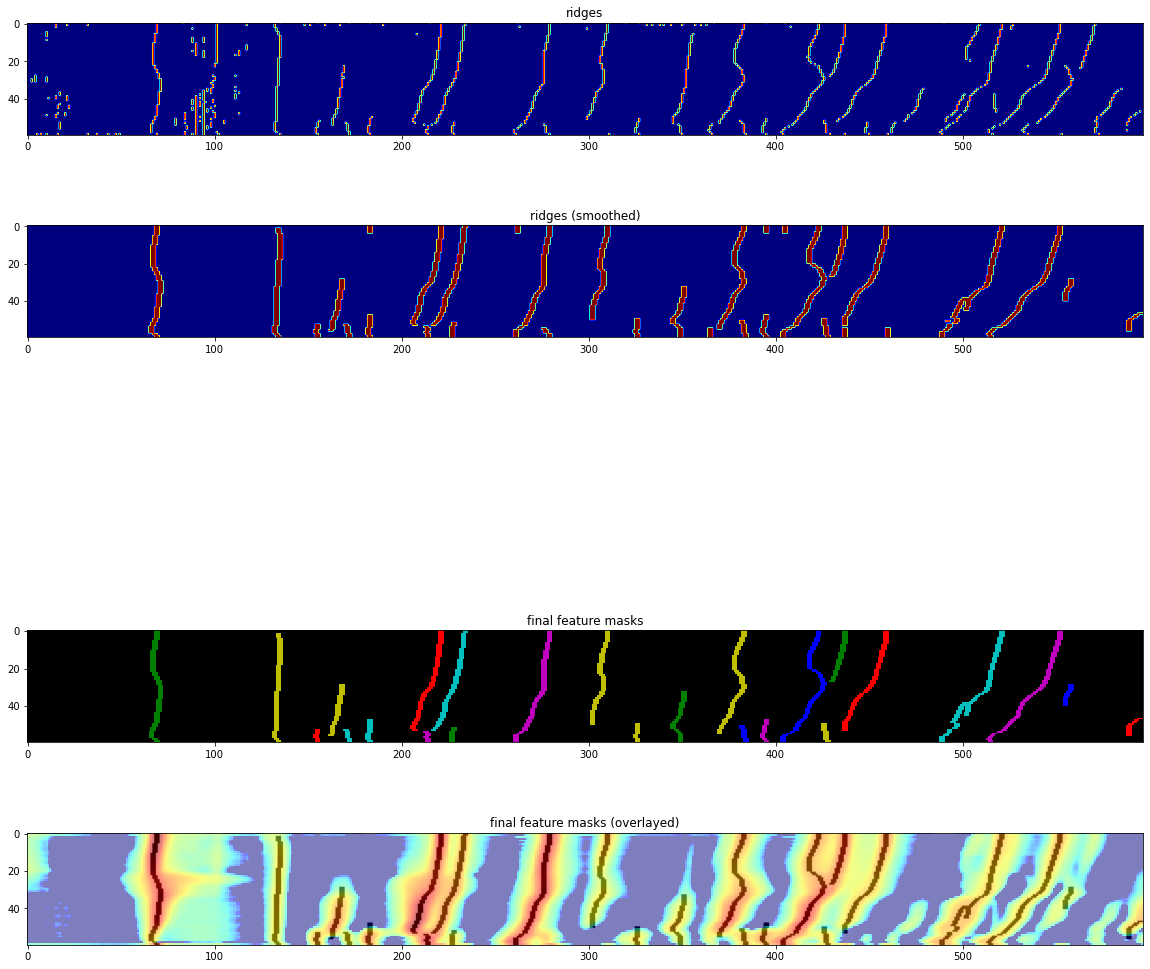

In [6]:
patterns_pp_simple = fast_q * (fast_q > 0)
labeled_simple, feature_masks_simple, activations_simple, _norm, activations_n1_simple =\
    default_featurize(patterns_pp_simple);
straightened_heatmap_simple = feat.get_peakshift_corrected_heatmap(patterns, activations_simple, labeled_simple)

In [7]:
# patterns_pp = fast_q - fast_q.min()
# patterns_pp /= patterns_pp.mean()
# fitlists = fsub_stop_2d[1]

# labeled, feature_masks, activations, norm_, activations_n1 = feat.peakfit_featurize(patterns_pp, fitlists,
#                                                                     size_thresh = 5, peakwidth = 1.5)

In [8]:
from xrdc import misc

{'linkage': 'ward', 'affinity': 'euclidean'}


/home/ollie/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


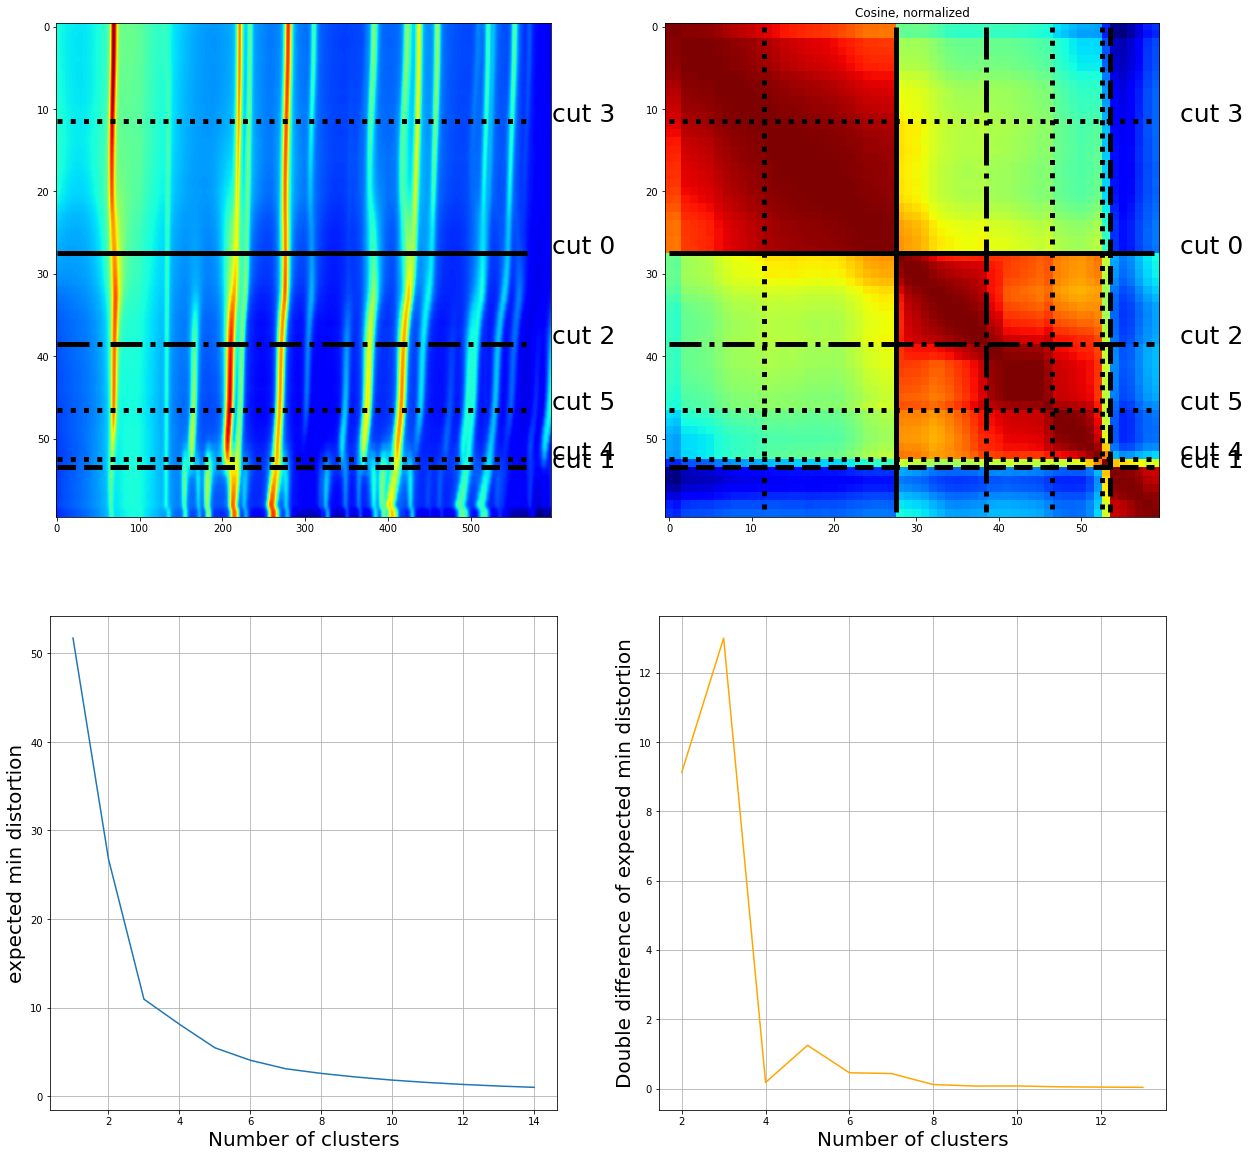

In [9]:
simtype = 'Cosine'
scaling = 'log'
linkage = 'ward'
ctype = 'agglom'

feature_csims1, o_cuts = feat.sims_with_boundaries(patterns, activations_n1_simple, activations_n1_simple, n = 7, simtype = simtype, extra_label='',
                    ctype = ctype, linkage = linkage, affinity = 'euclidean')

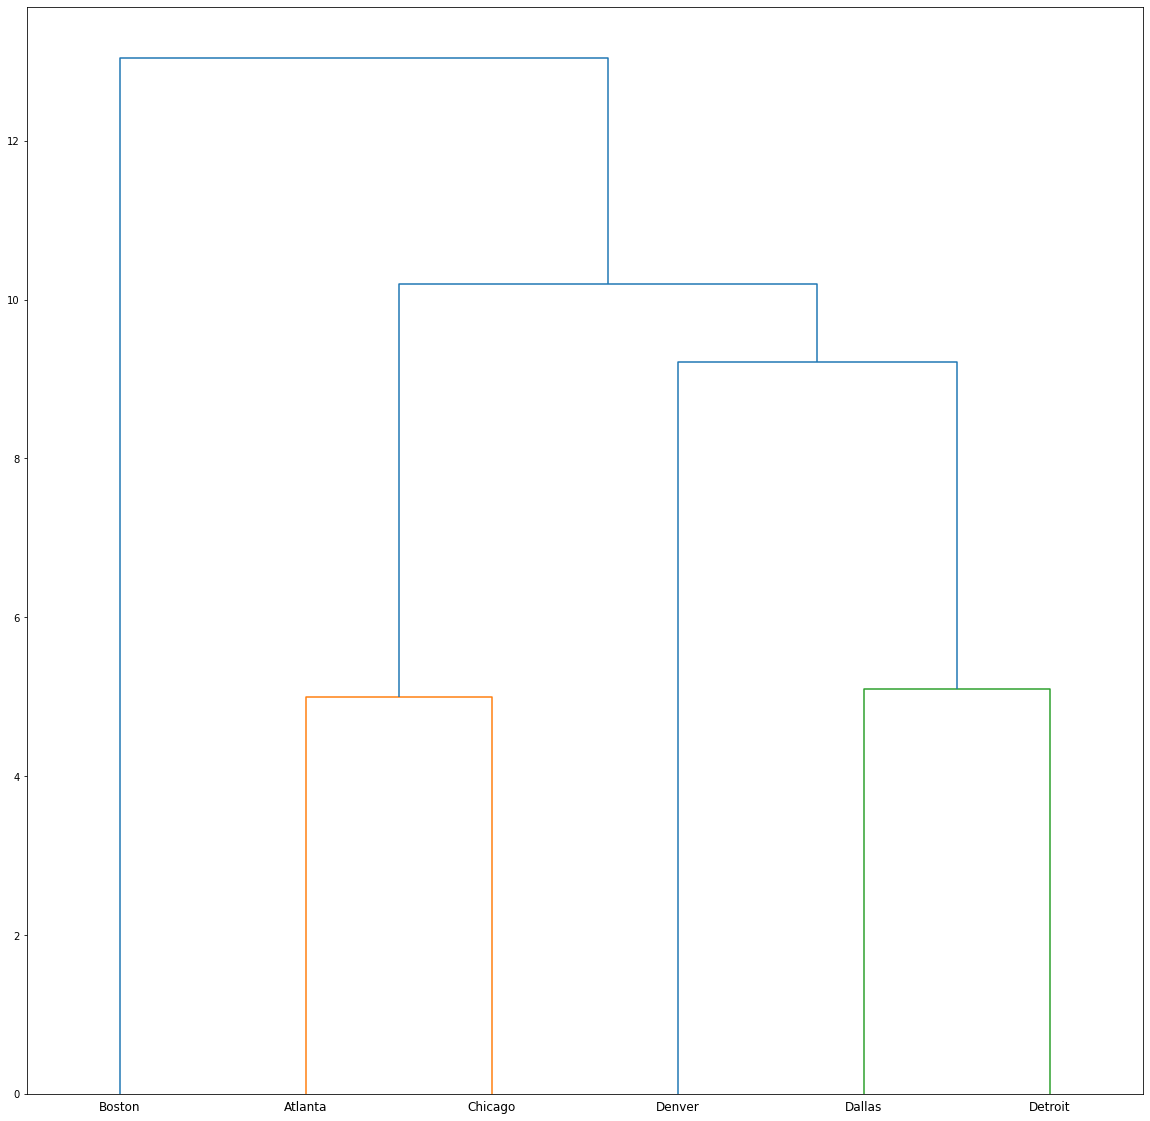

In [17]:
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

data = [[24, 16], [13, 4], [24, 11], [34, 18], [41, 
6], [35, 13]]
frame = pd.DataFrame(np.array(data), columns=["Rape", 
"Murder"], index=["Atlanta", "Boston", "Chicago", 
"Dallas", "Denver", "Detroit"])

Z = hierarchy.linkage(frame, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=frame.index)

In [10]:
act = activations_n1_simple

In [11]:
X = act.T

In [12]:
def l2_pairs(a):
    """
    Calculate L2 distances.
    """
    #b = b.reshape((b.shape[0], 1, a.shape[1]))
    b = a.reshape((a.shape[0], 1, a.shape[1]))
    dist_l2 = np.sqrt(np.einsum("ijk, ijk->ij", a - b, a - b))
    return dist_l2

In [13]:
def get_new_distance(new_size, imerge, jmerge, k, c_sizes, distances):
    N = (new_size + c_sizes[k])
    ai = ((c_sizes[imerge] + c_sizes[k]) / N)
    aj = ((c_sizes[jmerge] + c_sizes[k]) / N)
    b = ((c_sizes[k]) / N)
    return ai * distances[imerge, k] + aj * distances[jmerge, k] - b * distances[imerge, jmerge]

def agglom_step(distances, ids, clusters, c_sizes):
#     imerge, jmerge = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

#     imerge, jmerge = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

#     #newcluster = np.vstack((clusters[imerge], clusters[jmerge]))
#     newcluster = clusters[[imerge, jmerge]]
    
#     newcluster_ids = np.concatenate(ids[[imerge, jmerge]])[None, :]

#     idx_other = np.array(list(set(list(range(len(clusters)))) - set([imerge, jmerge])))

#     otherclusters = clusters[idx_other]

#     otherclusters_ids = ids[idx_other]

#     new_size = c_sizes[[imerge, jmerge]].sum()
#     others_sizes = c_sizes[idx_other]

#     # calculate new pairwise distance matrix
#     #new_distances_ij = np.array([get_new_distance(new_size, imerge, jmerge, , c_sizes) for k in idx_other])
#     new_distances_ij = get_new_distance(new_size, imerge, jmerge, idx_other, c_sizes, distances)
#     distances_tmp = distances[np.ix_(idx_other.ravel(), idx_other.ravel())]
#     distances_tmp = np.hstack((
#           np.vstack(([np.inf], new_distances_ij[:, None])),
#           np.vstack((new_distances_ij, distances_tmp))))

#     #clusters_tmp = np.array([newcluster] +  otherclusters, dtype = object)
#     clusters_tmp = np.array(([newcluster] + list(otherclusters)))

#     ids_tmp = np.array(list(newcluster_ids) + list(otherclusters_ids), dtype = object)

#     c_sizes_tmp = np.hstack((new_size, c_sizes[idx_other]))
#     return distances_tmp, ids_tmp, clusters_tmp, c_sizes_tmp
    imerge, jmerge = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    newcluster = np.vstack((clusters[imerge], clusters[jmerge]))
    
    newcluster_ids = np.concatenate(ids[[imerge, jmerge]])[None, :]

    idx_other = np.array(list(set(list(range(len(clusters)))) - set([imerge, jmerge])))

    otherclusters = [clusters[idx] for idx in idx_other]

    otherclusters_ids = ids[idx_other]

    new_size = c_sizes[[imerge, jmerge]].sum()
    others_sizes = c_sizes[idx_other]

    # calculate new pairwise distance matrix
    #new_distances_ij = np.array([get_new_distance(new_size, imerge, jmerge, , c_sizes) for k in idx_other])
    new_distances_ij = get_new_distance(new_size, imerge, jmerge, idx_other, c_sizes, distances)
    distances_tmp = distances[np.ix_(idx_other.ravel(), idx_other.ravel())]
    distances_tmp = np.hstack((
          np.vstack(([np.inf], new_distances_ij[:, None])),
          np.vstack((new_distances_ij, distances_tmp))))

    clusters_tmp = np.array([newcluster] + otherclusters, dtype = object)

    ids_tmp = np.array(list(newcluster_ids) + list(otherclusters_ids), dtype = object)

    c_sizes_tmp = np.hstack((new_size, c_sizes[idx_other]))
    return distances_tmp, ids_tmp, clusters_tmp, c_sizes_tmp

In [19]:
np.ix_?

In [206]:
clusters[idx_other].shape

(58,)

In [129]:
np.array(clusters).shape

(60, 1, 25)

In [221]:
get_new_distance(new_size, imerge, jmerge, idx_other, c_sizes, distances)

IndexError: index 5 is out of bounds for axis 0 with size 5

> <ipython-input-217-77488f83506a>(2)get_new_distance()
      1 def get_new_distance(new_size, imerge, jmerge, k, c_sizes, distances):
----> 2     N = (new_size + c_sizes[k])
      3     ai = ((c_sizes[imerge] + c_sizes[k]) / N)
      4     aj = ((c_sizes[jmerge] + c_sizes[k]) / N)
      5     b = ((c_sizes[k]) / N)

ipdb> c


In [14]:
# initialization

ids = np.arange(len(X))[:, None]

clusters = np.empty(shape = len(X), dtype = object)
clusters.fill(X[:, None])
#clusters = list(X[:, None])

distances = feat.l2_pairs(X)

c_sizes = np.array(misc.deepmap(clusters, lambda clust: len(clust), level = 1))

np.fill_diagonal(distances, np.inf)

In [15]:
for _ in range(55):
    distances, ids, clusters, c_sizes = agglom_step(distances, ids, clusters, c_sizes)

In [73]:
%timeit np.array([get_new_distance(new_size, imerge, jmerge, k, c_sizes) for k in idx_other])

61.9 µs ± 51.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [76]:
%timeit get_new_distance(new_size, imerge, jmerge, idx_other, c_sizes)

9.36 µs ± 14.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [212]:
%pdb

Automatic pdb calling has been turned ON


In [80]:
def do(distances, ids, clusters, c_sizes):
    for _ in range(55):
        distances, ids, clusters, c_sizes = agglom_step(distances, ids, clusters, c_sizes)
    return distances, ids, clusters, c_sizes

In [145]:
%timeit -n 1 -r 1 do(distances, ids, clusters, c_sizes)

5.48 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [60]:
from sklearn.cluster import AgglomerativeClustering

In [61]:
%timeit -n 1 -r 1 clustering = AgglomerativeClustering(n_clusters=5).fit(X)

411 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


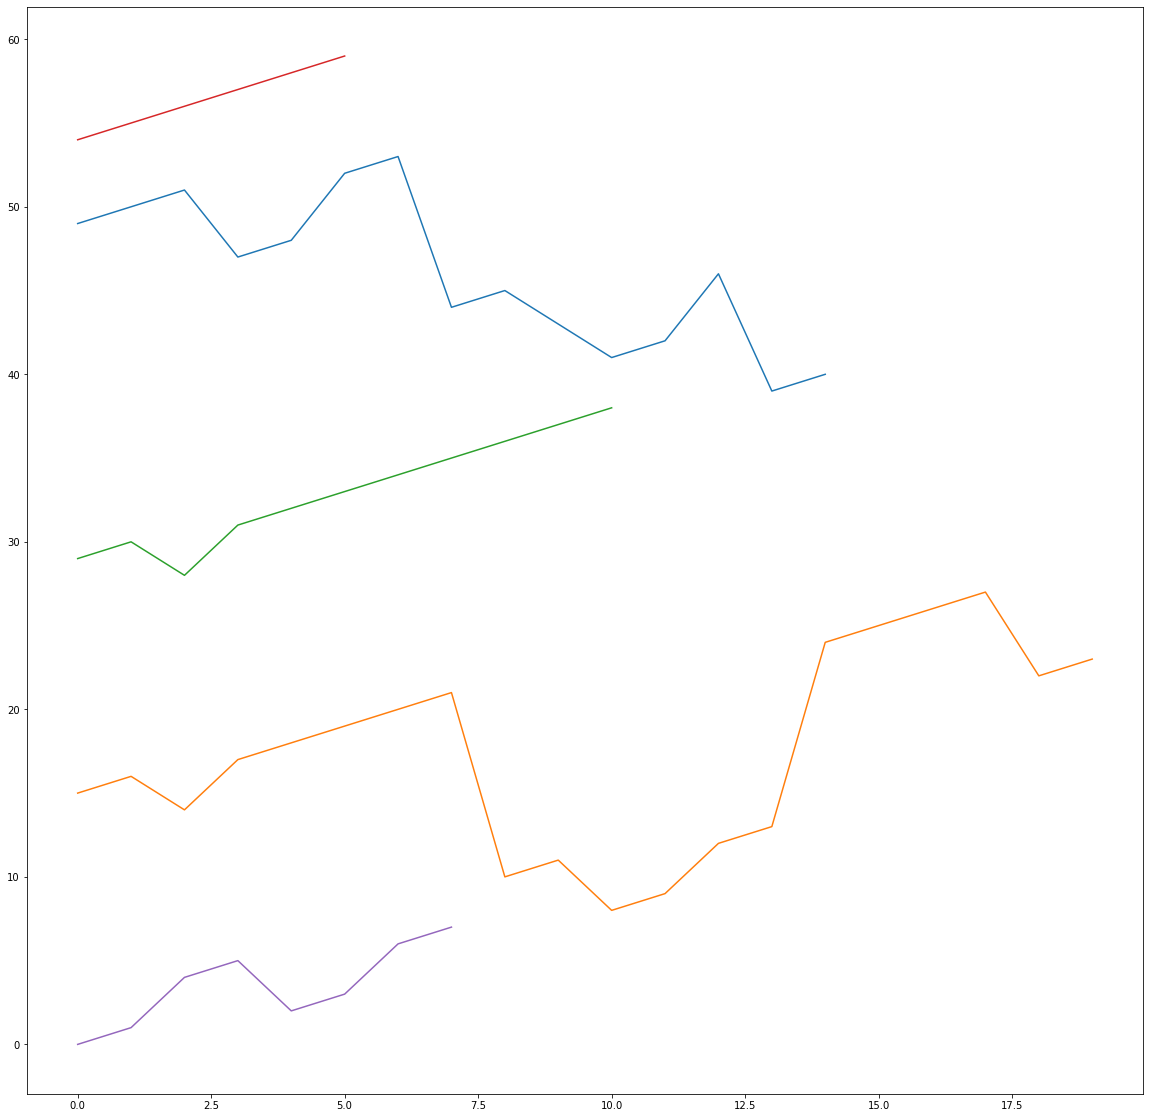

In [16]:
for row in ids:
    plt.plot(row)

In [35]:
ids, c_sizes

(array([array([49, 50, 51, 47, 48, 52, 53, 44, 45, 43, 41, 42, 46, 39, 40]),
        array([15, 16, 14, 17, 18, 19, 20, 21, 10, 11,  8,  9, 12, 13, 24, 25, 26,
               27, 22, 23])                                                       ,
        array([29, 30, 28, 31, 32, 33, 34, 35, 36, 37, 38]),
        array([54, 55, 56, 57, 58, 59]), array([0, 1, 4, 5, 2, 3, 6, 7])],
       dtype=object),
 array([15, 20, 11,  6,  8]))

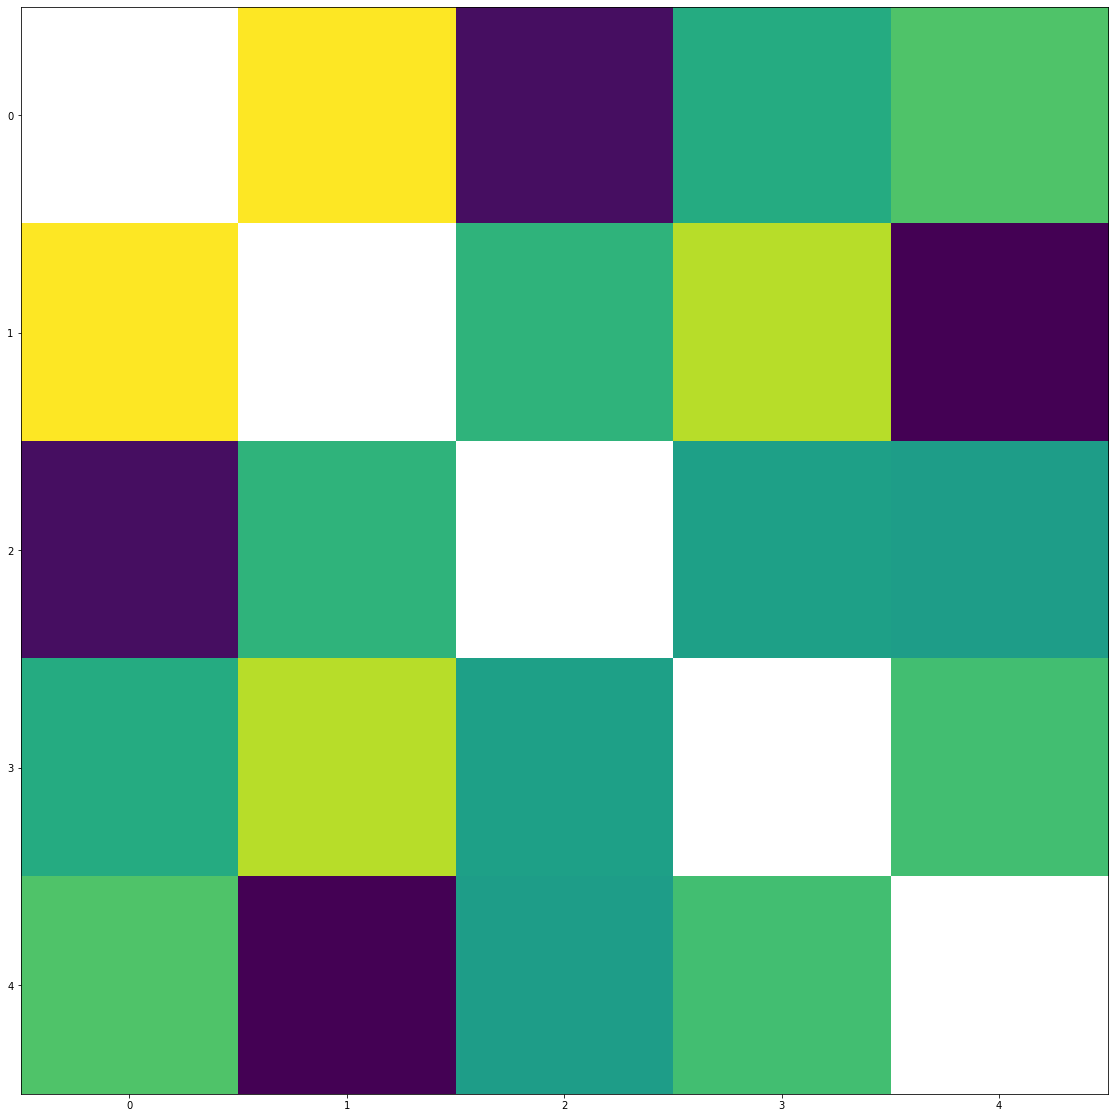

In [37]:
plt.imshow(distances)

In [38]:
#https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
#np.ix_(otherclusters_ids.ravel(), otherclusters_ids.ravel())